# Making a Parameterized Quantum Circuit (PQC) in Qiskit

### 1. generate_pqc.ipynb
### James Saslow
### 4/27/2024


____________________________________________________________________________________________________


This Jupyter Notebook constucts the Parameterized Quantum Circuit described in *Figure 1* in [1] in the Qiskit framework. Here, I prototype a PQC with 2 feature inputs $\vec{x} = (x_{0},x_{1})$ and 4 model weights $\vec{\omega} = (\omega_{0}, \omega_{1}, \omega_{2}, \omega_{3})$.


We start with encoding the unitary $U$. Recognizing that $U$ is a diagonal unitary with eigenvalues of phase $\alpha_{i}$, I can accomplish a gate composition of $U$ using $X$-Gates and control-phase gates. I utilize **ParameterVector** from Qiskit to keep these $\alpha_{i}$ values arbiitrary, so we can update them later on. Each $\alpha_{i}$ is defined as a linear combination of elements in $\vec{x}$ and $\vec{\omega}$. Then I apply the *U.control(1)* function to map $U$ to a *Controlled*-$U$ gate.

After defining the *Controlled*-$U$ gate, I begin building the Parameterized Quantum Circuit by first applying a Hadamard to all qubits, then a *Controlled*-$U$ gate, where the classifier qubit is the control qubit and the computational qubits are the target qubits. After this, a Hadamard gate is applied to the classifier qubit, which acts as an activation function. Then, the classifier qubit is measured.

The PQC is exported as a *.qpy* file called *parameterized_qc.qpy* to be later imported and used in *3.1 QNN_iris.ipynb*, *3.2 QNN_breast_cancer.ipynb*, and *QNN_MNIST.ipynb*.
_____________________________________________________________________________

[1] A. Daskin, “A simple quantum neural net with a periodic activation function,” 2018 IEEE International Conference on Systems, Man, and Cybernetics (SMC), Oct. 2018. doi:10.1109/smc.2018.00491 

In [1]:
# Importing Packages
from qiskit.circuit import Parameter
from qiskit.quantum_info import Operator
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import UnitaryGate
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, qpy

In [2]:
# Making a Parameterized Controlled - U Operation

U = QuantumCircuit(2, name='U')
# ===========================
# Defining Parameters
x     = ParameterVector('x', 2)
omega = ParameterVector('w', 4)
# ===========================
# Phase Encoding on |00> State
U.x(0)
U.x(1)
U.cp(x[0]*omega[0] + x[1]*omega[2] ,0,1)
U.x(0)
U.x(1)
# ===========================
# Phase Encoding on the |01> State
U.x(0)
U.cp(x[0]*omega[0] + x[1]*omega[3],0,1)
U.x(0)
# ===========================
# Phase Encoding on the |10> State
U.x(1)
U.cp(x[0]*omega[1] + x[1] * omega[2],0,1)
U.x(1)
# ===========================
# Phase Encoding on the |11> State
U.cp(x[0]*omega[1] + x[1]*omega[3],0,1)
# ===========================
# Transpiling Circuit
U = transpile(U)

# ===========================
# Mapping to Qiskit Gates

# Mapping to 2 Qubit Unitary
U_gate = U.to_gate()

# Mapping to Control 2 Qubit Unitary
CU_gate = U.control(1)

In [3]:
# Drawing the U Gate
U.draw()

┌───┐                                                           ┌───┐»
q_0: ┤ X ├─■───────────────────────────────■─────────────────────────┤ X ├»
     ├───┤ │P(w[0]*x[0] + w[2]*x[1]) ┌───┐ │P(w[0]*x[0] + w[3]*x[1]) ├───┤»
q_1: ┤ X ├─■─────────────────────────┤ X ├─■─────────────────────────┤ X ├»
     └───┘                           └───┘                           └───┘»
«                                                                
«q_0: ─■───────────────────────────────■─────────────────────────
«      │P(w[1]*x[0] + w[2]*x[1]) ┌───┐ │P(w[1]*x[0] + w[3]*x[1]) 
«q_1: ─■─────────────────────────┤ X ├─■─────────────────────────
«                                └───┘

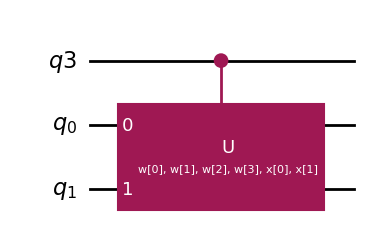

In [4]:
# Drawing the CU Gate
CU_gate.draw("mpl")

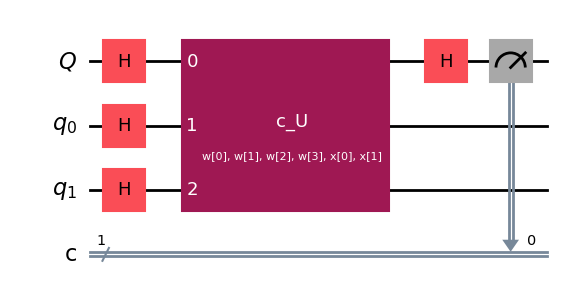

In [5]:
# Constructing the Parameterized Quantum Circuit

# ===============================================
# Specifying number of qubits in each register

num_classifier_qubits    = 1
num_computational_qubits = 2
num_qubits = num_classifier_qubits + num_computational_qubits

# ===============================================
# Initializing Registers & Quantum Circuit

q_class =  QuantumRegister(num_classifier_qubits   , name = 'Q')
q_comp  =  QuantumRegister(num_computational_qubits, name = 'q')
c       =  ClassicalRegister(1, name = 'c')
qc      =  QuantumCircuit(q_class,q_comp,c,name = 'qc')

# ===============================================
# Prototyping Quantum Gates

# Classifier Qubit gets initialized by a Hadamard
qc.h(q_class[0])

# Choosing our computational qubits to start in the equal coherent superposition state
qc.h(q_comp[0])
qc.h(q_comp[1])

# Applying a control Unitary
qc.append(CU_gate,[q_class[0],q_comp[0],q_comp[1]])

# Applying the Hadamard on classifier qubit as an activation function
qc.h(q_class[0])


# Measuring The Classifier Qubit
qc.measure(q_class[0], c[0])

# ===============================================
# Drawing Quantum Circuit
qc.draw("mpl")

In [6]:
# Exporting the Parameterized Quantum Circuit 'qc' as a .qpy file

with open("parameterized_qc.qpy", "wb") as qpy_file_write:
    qpy.dump(qc, qpy_file_write)